# Lecture 19: Maximum likelihood inference

[Maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is a general approach for estimating the parameters, $\theta$, of a model from data, $X$. We do this by first writing down the probability of the data as a function of the parameters -- this is called the **likelihood**

$$
\mathcal{L}(X|\theta)\,.
$$

Even in cases where the underlying model is deterministic, the measurements that give us the data are often stochastic. For example, we might estimate the fraction of people who are left handed by a survey of a small subset of the population.

In maximum likelihood inference, we search for the parameters $\hat{\theta}$ that maximize $\mathcal{L}(X|\theta)$. These are the parameters that, out of all the different possibilities, are the ones that are **most likely** to have produced the data $X$ that we observe.


### Example: Estimating the magnetic field coupled to a single spin

For an example, let's return to the case of the Ising model that we considered several weeks ago. To make things simple, let's consider just a single spin in an external magnetic field. Let's write the spin variable as $\sigma \in\{\pm 1\}$, and the energy

$$
E(\sigma) = -\epsilon \sigma\,.
$$

Here $\epsilon$ is the interaction energy -- the product of the external magnetic field and the magnetic moment of the spin itself -- which we would like to estimate.

In thermal equilibrium, the probability that the spin is in either state should be given by the Gibbs distribution

$$
\begin{align}
P(\sigma) &= \frac{e^{-E(\sigma)/T}}{Z}\,, \\
Z &= e^{-E(-1)/T} + e^{-E(1)/T}\,,
\end{align}
$$

where we've chosen units such that Boltzmann's constant $k_B=1$. First, let's code the Gibbs distribution.

In [0]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def gibbs(eps, T):
    """ This function takes the energy eps and temperature T as input
        and returns the Gibbs distribution for a single spin as output """
    
    Z     = np.exp(-eps/T) + np.exp(eps/T)
    p_pos = np.exp( eps/T) / Z
    p_neg = np.exp(-eps/T) / Z
    
    return p_pos, p_neg

### Generating sample data

Next, let's imagine that we make 100 observations of the system and measure the direction of the spin. We can sample those observations from the Gibbs distribution. We'll set $\epsilon=0.1$ and take $T=1$.

In [3]:
import numpy.random as rng

eps_true = 0.1
T        = 1

p_pos, p_neg = gibbs(eps_true, T)

spin_measurements = np.zeros(100)

for i in range(len(spin_measurements)):
  if rng.rand()<p_pos:
    spin_measurements[i] = 1
  else:
    spin_measurements[i] = -1
    
print(spin_measurements)
print(np.sum(spin_measurements)/len(spin_measurements))

[ 1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.
  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.
 -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.
 -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
0.06


### Computing the likelihood

How likely are different values for $\epsilon$ to have generated this data? This is given by the likelihood function $\mathcal{L}$. Here, all the measurements of the spin direction are independent, so the likelihood is

$$
\mathcal{L}(\{\sigma_i\}|\epsilon) = \prod_{i=1}^{100} P_\epsilon(\sigma_i)\,.
$$

In the equation above, $\sigma_i$ refers to the $i$th measurement of the spin, and $P_\epsilon(\sigma)$ denotes the probability of the spin being in state $\sigma$ given that the interaction energy is $\epsilon$.

With a large number of observations, the likelihood may be challenging to work with numerically because it rapidly becomes very small. Often we work with the logarithm of the likelihood, referred to as the log-likelihood, instead. Because the logarithm is a monotonic function, maximizing the log-likelihood $\ell$ is equivalent to maximizing the likelihood $\mathcal{L}$. The expression for the log-likelihood is

$$
\ell (\{\sigma_i\}|\epsilon) = \log\left[\mathcal{L}(\{\sigma_i\}|\epsilon)\right] = \sum_{i=1}^{100} \log\left(P_\epsilon(\sigma_i)\right)\,.
$$

Now, instead of a product of many terms, we have a sum. Below, let's compute the log-likelihood and plot it as a function of $\epsilon$.

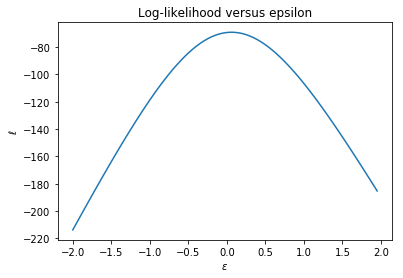

In [4]:
def get_ell(p_pos, p_neg, data):
    return np.sum(data==1)*np.log(p_pos) + np.sum(data==-1)*np.log(p_neg)


eps_vals = np.arange(-2, 2, 0.05)
ell_vals = []

for eps in eps_vals:
  p_pos, p_neg = gibbs(eps, T)
  ell_vals.append(get_ell(p_pos, p_neg, spin_measurements))


sns.lineplot(eps_vals, ell_vals)
plt.xlabel('$\epsilon$')
plt.ylabel('$\ell$')
plt.title('Log-likelihood versus epsilon');

### Estimating the interaction energy

**Exercise:** using the formula that we derived, fill in the code below to derive the maximum likelihood estimate of $\epsilon$ for a given set of data.

In [5]:
def get_eps(data):
    return np.arctanh(np.sum(data)/len(data))

print('For this data, the estimated epsilon = %.2e, true value = %.2e' % (get_eps(spin_measurements), eps_true))

For this data, the estimated epsilon = 6.01e-02, true value = 1.00e-01


### Robustness to finite sampling

How stable are our estimates, depending on the amount of data that we have? Below, we'll experiment with using smaller or larger sample sizes. We can also test these results with different values of $\epsilon$.

In [19]:
eps_true = 1.
T        = 1

p_pos, p_neg = gibbs(eps_true, T)

spin_measurements = np.zeros(100)

for i in range(len(spin_measurements)):
  if rng.rand()<p_pos:
    spin_measurements[i] = 1
  else:
    spin_measurements[i] = -1
    
print(np.sum(spin_measurements)/len(spin_measurements))

print('For this data, the estimated epsilon = %.2e, true value = %.2e' % (get_eps(spin_measurements), eps_true))

0.84
For this data, the estimated epsilon = 1.22e+00, true value = 1.00e+00


### Finding the parameters using optimization

In this simple case we can derive an analytical expression for the maximum likelihood estimate of $\epsilon$, but in more general cases this is usually impossible. Instead, we may need to numerically maximize the likelihood. Here, we will apply the steepest descent algorithm (with line search) to this problem. Note that we need to rearrange our problem in order to **minimize** the **negative** of the log-likelihood with this approach.

In [20]:
def f(x):
    """ Return minus the log-likelihood of the data at x = epsilon. """
    p_pos, p_neg = gibbs(x, 1)
    return -np.sum(spin_measurements==1)*np.log(p_pos) -np.sum(spin_measurements==-1)*np.log(p_neg)

def df(x):
    """ Return the derivative of minus the log-likelihood at x = epsilon. """
    p_pos, p_neg = gibbs(x, 1)
    return -np.sum(spin_measurements) + len(spin_measurements)*(p_pos - p_neg)


# Set line search parameters

beta1 = 0.4    # Step size multiplier if sufficient decrease fails
beta2 = 1.2    # Step size multiplier if curvature condition fails
alpha = 0.001  # Sufficient decrease parameter
gamma = 0.5    # Curvature condition parameter


# Set steepest descent parameters

epsilon  = 0.001  # Stopping condition -- end when |df/dx| < epsilon 
max_iter = 100    # Maximum number of iterations
it       = 0      # Current iteration


# Initialize and iteratre

x0   = 0      # Starting value of parameter
x    = x0     # Current value of the parameter
dfdx = df(x0) # Starting value of the derivative df/dx

# Report status
print('iter\tx\tf(x)\tdf/dx')

# Now loop through the steepest descent algorithm

while np.fabs(dfdx)>=epsilon and it<max_iter:
    
    # Report status
    print('%d\t%.4f\t%.4f\t%.4f' % (it, x, f(x), dfdx))
    
    # Choose the step direction
    s = -df(x)
    
    # Choose how far to step in that direction
    t = 1 
    both_passed = False
    
    while not both_passed:

        # Check for sufficient decrease fail

        if f(x + (t*s)) > f(x) + (alpha * t * np.dot(df(x), s)):
            print('\tSufficient decrease failed, reducing t %lf --> %lf' % (t, beta1*t))
            t = beta1 * t

        # If passed, check for curvature condition fail

        elif np.dot(df(x + (t*s)), s) < gamma * np.dot(df(x), s):
            print('\tCurvature condition failed, increasing t %lf --> %lf' % (t, beta2*t))
            t = beta2 * t

        # If both passed, exit the loop

        else:
            both_passed = True

    print('\tThe accepted step length is %lf' % t)
    
    # Update the parameters
    x = x + t*s
    
    # Update the derivative
    dfdx = df(x)
    
    # Update the iteration counter
    it += 1
    
# Report the minimum

true_min = np.arctanh((np.sum(spin_measurements==1)-np.sum(spin_measurements==-1)) / len(spin_measurements))

print('\nFound the minimum near x* = %lf, true minimum is %lf' % (x, true_min))

iter	x	f(x)	df/dx
0	0.0000	69.3147	-84.0000
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	Sufficient decrease failed, reducing t 0.400000 --> 0.160000
	Sufficient decrease failed, reducing t 0.160000 --> 0.064000
	Sufficient decrease failed, reducing t 0.064000 --> 0.025600
	The accepted step length is 0.025600
1	2.1504	35.7531	13.3247
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	Sufficient decrease failed, reducing t 0.400000 --> 0.160000
	Sufficient decrease failed, reducing t 0.160000 --> 0.064000
	The accepted step length is 0.064000
2	1.2976	27.9594	2.1109
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	Sufficient decrease failed, reducing t 0.400000 --> 0.160000
	Sufficient decrease failed, reducing t 0.160000 --> 0.064000
	The accepted step length is 0.064000
3	1.1625	27.9293	-1.8140
	Sufficient decrease failed, reducing t 1.000000 --> 0.400000
	Sufficient decrease failed, reducing t 0.400000 --> 0.160000
	Sufficient decrease fai